# Exercises 03 Answers: Deep Learning

### Important Note: Enabling GPU
To make sure this is enabled, go to the "Runtime" menu at the top of the page, and click select the "Change Runtime Type" option. Under "Hardware Accelerator", choose "GPU" and then hit "Save". 

## Exercise 1

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


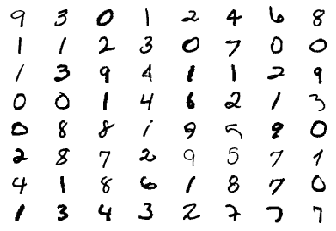

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299167
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.371705
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.231145
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.320367
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.119745
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.206420
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.096997
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.097689
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.103046
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.184913

Test set: Average loss: 932.5730, Accuracy: 9702/10000 (97%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


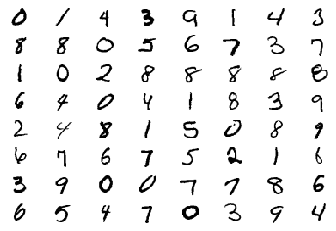

Preds:
0,1,4,3,9,1,4,3,
8,8,0,5,6,7,3,7,
1,0,2,8,8,8,8,8,
6,4,0,4,1,8,3,9,
2,4,8,1,5,0,8,9,
6,7,6,7,5,2,1,6,
3,9,0,0,7,7,8,6,
6,5,4,7,0,3,9,4,


In [5]:
import itertools

import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 1
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)

    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))

    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()

## Exercise 02:

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


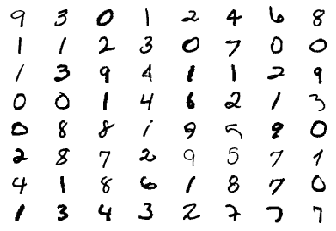

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299167
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.357202
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.211243
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.307516
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.114778
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.206735
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.079370
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.096651
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.098301
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.207567

Test set: Average loss: 950.4646, Accuracy: 9701/10000 (97%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


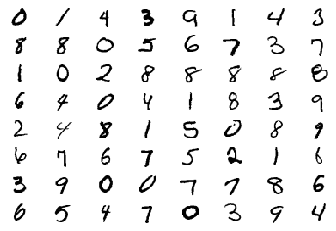

Preds:
0,1,4,3,9,1,4,3,
8,8,0,5,6,7,3,7,
1,0,2,8,8,8,8,8,
6,4,0,4,1,8,3,9,
2,4,8,1,5,0,8,9,
6,7,6,7,5,2,1,6,
3,9,0,0,7,7,8,6,
6,5,4,7,0,3,9,4,
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.019083
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.020515
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.074138
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.089087
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.061512
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.117131
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.087690
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.051915
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.189193
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.129969

Test set: Average loss: 809.4124, Accuracy: 9777/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


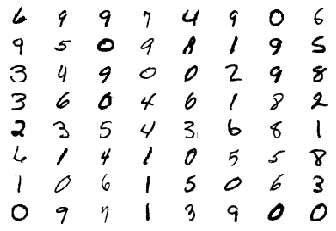

Preds:
6,9,9,7,4,9,0,6,
9,5,0,9,8,1,9,5,
3,4,9,0,0,2,9,8,
3,6,0,4,0,1,8,2,
2,3,5,4,3,6,8,1,
6,1,4,1,0,5,5,8,
1,0,6,1,5,0,6,3,
0,9,7,1,3,9,0,0,
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.060522
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.165920
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.040612
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.133457
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.097807
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.026693
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.013635
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.146333
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019522
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027710

Test set: Average loss: 642.2662, Accuracy: 9813/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


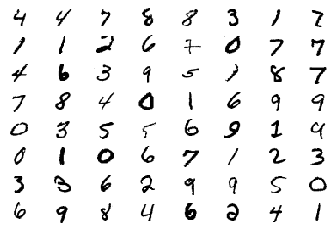

Preds:
4,4,7,8,8,3,1,7,
1,1,2,6,7,0,7,7,
4,6,3,9,5,8,8,7,
7,8,4,0,1,6,9,9,
0,3,5,5,6,9,1,4,
0,1,0,6,7,1,2,3,
3,3,6,2,9,9,5,0,
6,9,8,4,6,2,4,1,
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.010860
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.030950
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.102882
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.036485
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.123987
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.006605
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.138495
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.051157
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.016411
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.042781

Test set: Average loss: 649.4027, Accuracy: 9812/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


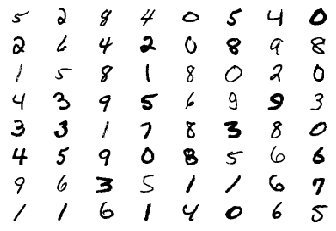

Preds:
5,2,8,4,0,5,4,0,
2,6,4,2,0,8,9,8,
1,5,8,1,8,0,2,0,
4,3,9,5,6,9,9,3,
3,3,1,7,8,3,8,0,
4,5,9,0,8,5,6,6,
9,6,3,5,1,1,6,7,
1,1,6,1,4,0,6,5,
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.015018
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.084985
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.047905
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.103088
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.019061
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.051402
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.035470
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.081373
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.017538
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.025497

Test set: Average loss: 629.9002, Accuracy: 9835/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


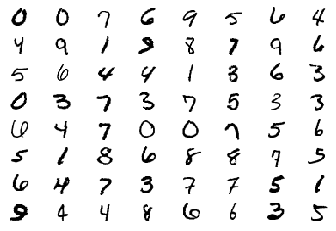

Preds:
0,0,7,6,9,5,6,4,
4,9,1,2,8,7,9,6,
5,6,4,4,1,3,6,3,
0,3,7,3,7,5,3,3,
0,4,7,0,0,7,5,6,
5,1,8,6,8,8,7,5,
6,4,7,3,7,7,5,1,
5,4,4,8,6,6,3,5,
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.001756
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.011722
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.028814
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.003321
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.033524
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.009345
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.199537
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.113715
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.056253
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.010507

Test set: Average loss: 639.8114, Accuracy: 9826/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


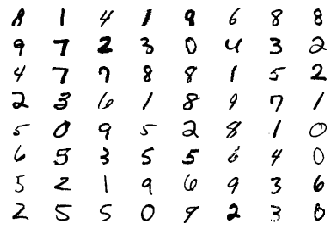

Preds:
1,1,4,1,8,6,8,8,
9,7,2,3,0,4,3,2,
4,7,7,8,8,1,5,2,
2,3,6,1,8,9,7,1,
5,0,9,5,2,8,1,0,
6,5,3,5,5,6,4,0,
5,2,1,9,6,9,3,6,
2,5,5,0,9,2,3,0,
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.037306
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.077332
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.007207
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.006035
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.034934
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.073340
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.065973
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.188727
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.123611
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.003031

Test set: Average loss: 584.8932, Accuracy: 9834/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


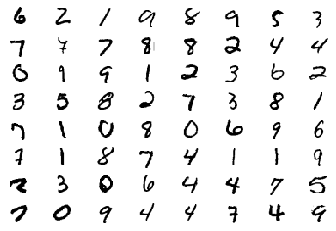

Preds:
6,2,1,9,8,9,5,3,
7,4,7,8,8,2,4,4,
0,9,9,1,2,3,6,2,
3,5,8,2,7,3,8,1,
7,1,0,8,0,6,9,6,
7,1,8,7,4,1,1,9,
7,3,0,6,4,4,7,5,
7,0,9,4,4,7,4,9,
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.022882
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.123360
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.100022
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.005931
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.024300
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.005976
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.015142
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.005145
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.002173
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.011179

Test set: Average loss: 664.1514, Accuracy: 9829/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


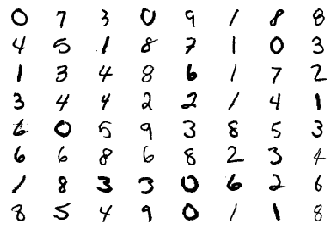

Preds:
0,7,3,0,9,1,8,0,
4,5,1,8,7,1,0,3,
1,3,4,8,6,1,7,2,
3,4,4,2,2,1,4,1,
6,0,5,9,3,8,5,3,
6,6,8,6,8,2,3,4,
1,8,3,3,0,6,2,6,
8,5,4,9,0,1,1,8,
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.032707
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.011121
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.041436
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000694
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000646
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000941
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.024712
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.028555
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.055128
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.118309

Test set: Average loss: 620.1882, Accuracy: 9829/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


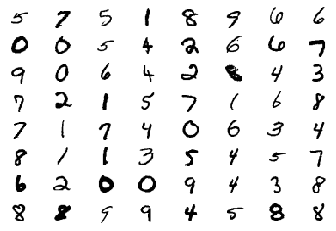

Preds:
5,7,5,1,8,9,6,6,
0,0,5,4,2,6,6,7,
9,0,6,4,2,8,4,3,
7,2,1,5,7,1,6,8,
7,1,7,4,0,6,3,4,
8,1,1,3,5,4,5,7,
6,2,0,0,9,4,3,8,
8,8,9,9,4,5,8,8,
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.006797
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.031993
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.004496
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.010435
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.026117
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.016928
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.033698
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.031250
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.088239
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.099822

Test set: Average loss: 704.7145, Accuracy: 9845/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


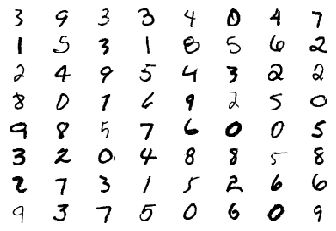

Preds:
3,9,3,3,4,0,4,7,
1,5,3,1,8,5,6,2,
2,4,9,5,4,3,2,2,
8,0,7,6,9,2,5,0,
9,8,5,7,6,0,0,5,
3,2,0,4,8,8,5,8,
2,7,3,1,5,2,6,6,
9,3,7,5,0,6,0,9,


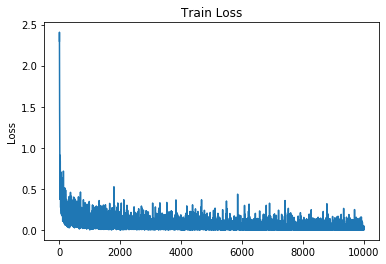

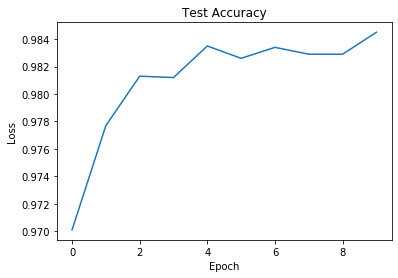

In [12]:
import itertools

import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 10
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)
    
    train_losses_per_epoch = np.zeros(ITER_PER_EPOCH)
    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(train_losses_per_epoch.mean())
    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        test_accuracies.append(correct / total)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))
        
    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()
plt.plot(train_losses)
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Accuracy')
plt.show()

## Exercise 03:

## Increasing Dropout
Results are too noisy and it fails to learn anything at all.

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


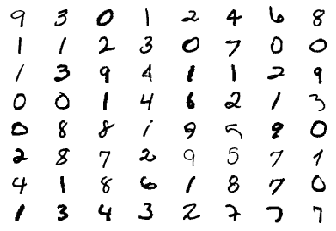

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299917
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.300696
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.299616
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.305050
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.288922
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.298429
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.291141
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.301020
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.298804
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.296535

Test set: Average loss: 23009.8469, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


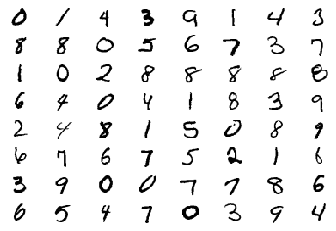

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297082
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.306136
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.304607
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.293906
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.306758
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.304788
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.305722
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.296390
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.295220
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.307647

Test set: Average loss: 23011.0571, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


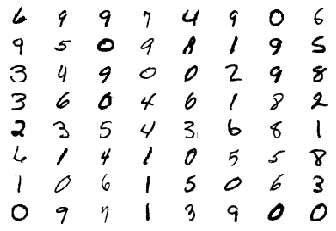

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.296305
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.305427
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.297406
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.290376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.303162
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.307770
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.292444
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.287831
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.305775
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.300337

Test set: Average loss: 23011.3667, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


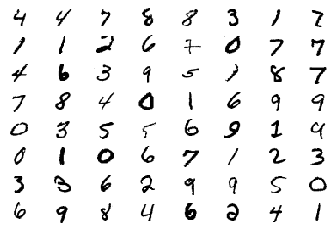

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.299839
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.297748
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.298100
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.295911
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.298463
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.315792
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.311137
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.298422
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.306098
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.297260

Test set: Average loss: 23010.8398, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


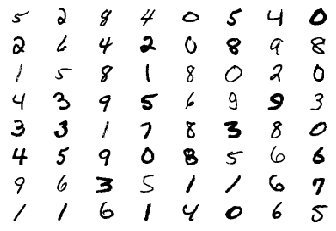

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.299304
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.298474
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.290417
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.301127
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.300173
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.302722
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.283738
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.301542
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.294650
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.288509

Test set: Average loss: 23011.0117, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


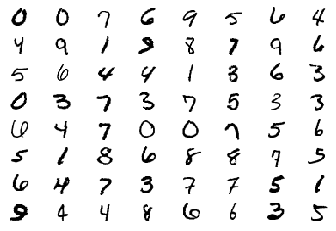

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.304637
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.311639
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.309575
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.293053
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.307488
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.297432
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.300417
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.310359
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.296351
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.295129

Test set: Average loss: 23010.2715, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


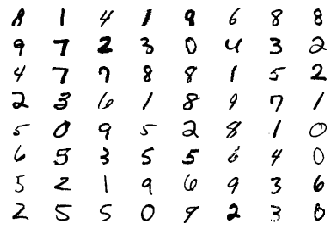

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.302951
Train Epoch: 6 [6400/60000 (11%)]	Loss: 2.302223
Train Epoch: 6 [12800/60000 (21%)]	Loss: 2.290329
Train Epoch: 6 [19200/60000 (32%)]	Loss: 2.297698
Train Epoch: 6 [25600/60000 (43%)]	Loss: 2.290558
Train Epoch: 6 [32000/60000 (53%)]	Loss: 2.295378
Train Epoch: 6 [38400/60000 (64%)]	Loss: 2.315514
Train Epoch: 6 [44800/60000 (75%)]	Loss: 2.290358
Train Epoch: 6 [51200/60000 (85%)]	Loss: 2.305767
Train Epoch: 6 [57600/60000 (96%)]	Loss: 2.288373

Test set: Average loss: 23010.7297, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


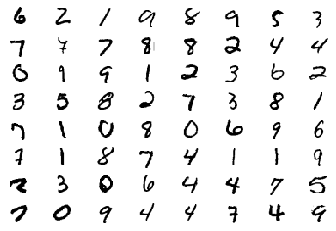

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.308383
Train Epoch: 7 [6400/60000 (11%)]	Loss: 2.296911
Train Epoch: 7 [12800/60000 (21%)]	Loss: 2.313267
Train Epoch: 7 [19200/60000 (32%)]	Loss: 2.308046
Train Epoch: 7 [25600/60000 (43%)]	Loss: 2.300103
Train Epoch: 7 [32000/60000 (53%)]	Loss: 2.301179
Train Epoch: 7 [38400/60000 (64%)]	Loss: 2.299993
Train Epoch: 7 [44800/60000 (75%)]	Loss: 2.297909
Train Epoch: 7 [51200/60000 (85%)]	Loss: 2.301634
Train Epoch: 7 [57600/60000 (96%)]	Loss: 2.307395

Test set: Average loss: 23010.1338, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


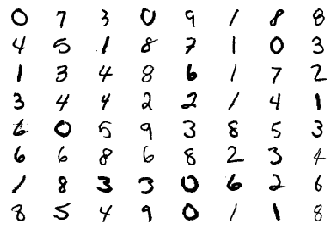

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.305959
Train Epoch: 8 [6400/60000 (11%)]	Loss: 2.297342
Train Epoch: 8 [12800/60000 (21%)]	Loss: 2.300409
Train Epoch: 8 [19200/60000 (32%)]	Loss: 2.314145
Train Epoch: 8 [25600/60000 (43%)]	Loss: 2.311251
Train Epoch: 8 [32000/60000 (53%)]	Loss: 2.300881
Train Epoch: 8 [38400/60000 (64%)]	Loss: 2.306387
Train Epoch: 8 [44800/60000 (75%)]	Loss: 2.303151
Train Epoch: 8 [51200/60000 (85%)]	Loss: 2.294713
Train Epoch: 8 [57600/60000 (96%)]	Loss: 2.302924

Test set: Average loss: 23010.0791, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


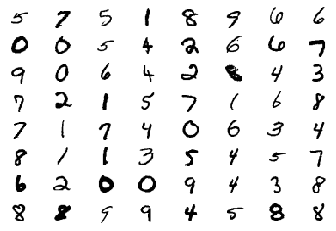

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.300451
Train Epoch: 9 [6400/60000 (11%)]	Loss: 2.295859
Train Epoch: 9 [12800/60000 (21%)]	Loss: 2.312506
Train Epoch: 9 [19200/60000 (32%)]	Loss: 2.303658
Train Epoch: 9 [25600/60000 (43%)]	Loss: 2.311610
Train Epoch: 9 [32000/60000 (53%)]	Loss: 2.296115
Train Epoch: 9 [38400/60000 (64%)]	Loss: 2.297035
Train Epoch: 9 [44800/60000 (75%)]	Loss: 2.301519
Train Epoch: 9 [51200/60000 (85%)]	Loss: 2.304328
Train Epoch: 9 [57600/60000 (96%)]	Loss: 2.307180

Test set: Average loss: 23010.1758, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


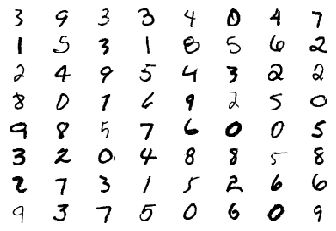

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,


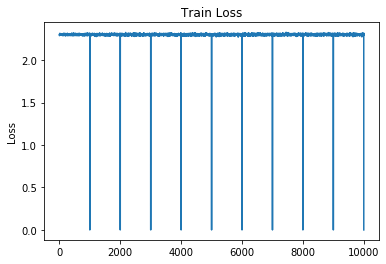

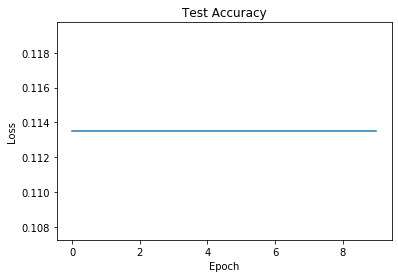

In [13]:
import itertools

import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(1.0)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 10
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)
    
    train_losses_per_epoch = np.zeros(ITER_PER_EPOCH)
    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(train_losses_per_epoch.mean())
    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        test_accuracies.append(correct / total)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))
        
    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()
plt.plot(train_losses)
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Accuracy')
plt.show()

## Decreasing Dropout
Test accuracy improves slightly. Maybe there was too much Dropout added initially?

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


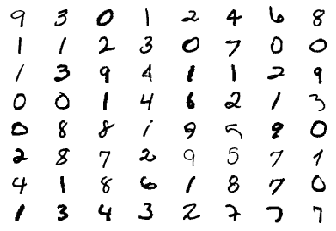

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310136
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.237912
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.122174
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.092058
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.036760
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.095174
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.104340
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.144762
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.103470
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.203577

Test set: Average loss: 668.4533, Accuracy: 9783/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


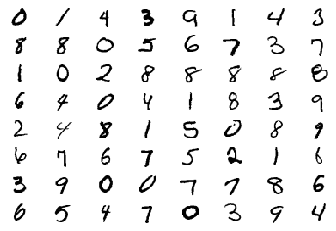

Preds:
0,1,4,3,9,1,4,3,
8,8,0,5,6,7,3,7,
1,0,2,8,8,8,8,0,
6,4,0,4,1,8,3,9,
2,4,8,1,5,0,8,9,
6,7,6,7,5,2,1,6,
3,9,0,0,7,7,8,6,
6,5,4,7,0,3,9,4,
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.016456
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.022149
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.009552
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.068459
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.036090
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.104650
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.007342
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.014937
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.086908
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.095032

Test set: Average loss: 504.8076, Accuracy: 9840/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


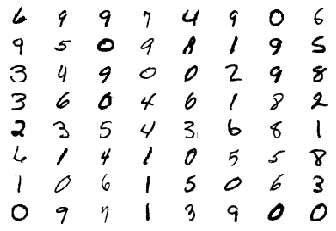

Preds:
6,9,9,7,4,9,0,6,
9,5,0,9,8,1,9,5,
3,4,9,0,0,2,9,8,
3,6,0,4,6,1,8,2,
2,3,5,4,3,6,8,1,
6,1,4,1,0,3,5,8,
1,0,6,1,5,0,6,3,
0,9,7,1,3,9,0,0,
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.012871
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.097979
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.006203
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.105265
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.009431
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.011550
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.009185
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.093359
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.038873
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.005533

Test set: Average loss: 465.2124, Accuracy: 9863/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


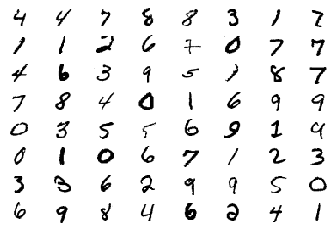

Preds:
4,4,7,8,8,3,1,7,
1,1,2,6,7,0,7,7,
4,6,3,9,5,1,8,7,
7,8,4,0,1,6,9,9,
0,3,5,5,6,9,1,4,
0,1,0,6,7,1,2,3,
3,5,6,2,9,9,5,0,
6,9,8,4,6,2,4,1,
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.005525
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.036796
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.032013
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.092042
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.017151
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.017187
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.123080
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.001869
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.010854
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.029805

Test set: Average loss: 496.7448, Accuracy: 9858/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


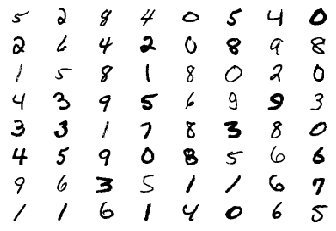

Preds:
5,2,8,4,0,5,4,0,
2,6,4,2,0,8,9,8,
1,5,8,1,8,0,2,0,
4,3,9,5,6,9,9,3,
3,3,1,7,8,3,8,0,
4,5,9,0,8,5,6,6,
9,6,3,5,1,1,6,7,
1,1,6,1,4,0,6,5,
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.008763
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.008890
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.119928
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.078496
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.061292
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.007593
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.027061
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.137737
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.004141
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.012993

Test set: Average loss: 460.9802, Accuracy: 9869/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


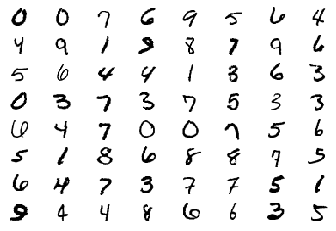

Preds:
0,0,7,6,9,5,6,4,
4,9,1,9,8,7,9,6,
5,6,4,4,1,3,6,3,
0,3,7,3,7,5,3,3,
8,4,7,0,0,7,5,6,
5,1,8,6,8,8,7,5,
6,4,7,3,7,7,5,1,
5,4,4,8,6,6,3,5,
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.086974
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.005814
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.007137
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000692
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.020529
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001339
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.132773
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.123520
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001980
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.008045

Test set: Average loss: 538.5833, Accuracy: 9872/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


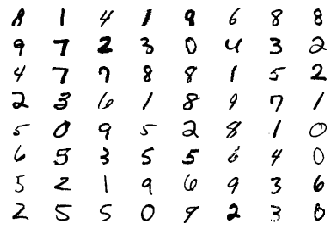

Preds:
1,1,4,1,8,6,8,8,
9,7,2,3,0,4,3,2,
4,7,7,8,8,1,5,2,
2,3,6,1,8,9,7,1,
5,0,9,5,2,8,1,0,
6,5,3,5,5,6,4,0,
5,2,1,9,6,9,3,6,
2,5,5,0,9,2,3,6,
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001518
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000195
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.001900
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.022223
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.004133
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.015336
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.005457
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000166
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.044501
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.002017

Test set: Average loss: 438.1039, Accuracy: 9877/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


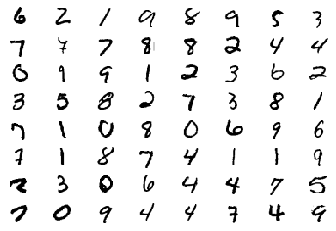

Preds:
6,2,1,9,8,9,5,3,
7,7,7,8,8,2,4,4,
0,9,9,1,2,3,6,2,
3,5,8,2,7,3,8,1,
7,1,0,8,0,6,9,6,
7,1,8,7,4,1,1,9,
7,3,0,6,4,4,7,5,
7,0,9,4,4,7,4,9,
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.001077
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.001225
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.036801
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000182
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.003828
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.009376
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.037479
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.005265
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.002079
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.015926

Test set: Average loss: 498.9049, Accuracy: 9877/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


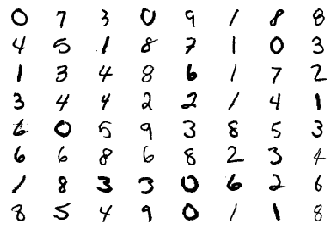

Preds:
0,7,3,0,9,1,8,8,
4,5,1,8,7,1,0,3,
1,3,4,8,6,1,7,2,
3,4,4,2,2,1,4,1,
6,0,5,9,3,8,5,3,
6,6,8,6,8,2,3,4,
1,8,3,3,0,6,2,6,
8,5,4,9,0,1,1,8,
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000688
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001023
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.017171
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.006069
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001317
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000078
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.002147
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.001773
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.020591
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000301

Test set: Average loss: 590.0382, Accuracy: 9860/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


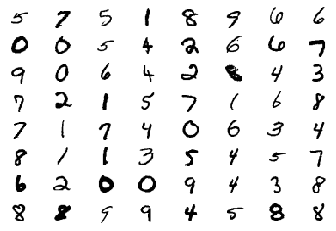

Preds:
5,7,5,1,8,9,6,6,
0,0,5,4,2,6,6,7,
9,0,6,4,2,8,4,3,
7,2,1,5,7,1,6,8,
7,1,7,4,0,6,3,4,
8,1,1,3,5,4,5,7,
6,2,0,0,9,4,3,8,
8,8,9,9,4,5,8,8,
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000036
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000065
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001270
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.002304
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.001970
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.001566
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.002034
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.006256
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.015925
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.019276

Test set: Average loss: 513.8773, Accuracy: 9888/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


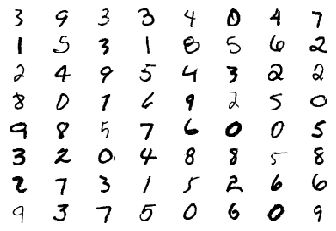

Preds:
3,9,3,3,4,0,4,7,
1,5,3,1,8,5,6,2,
2,4,9,5,4,3,2,2,
8,0,7,6,9,2,5,0,
9,8,5,7,6,0,0,5,
3,2,0,4,8,8,5,8,
2,7,3,1,5,2,6,6,
9,3,7,5,0,6,0,9,


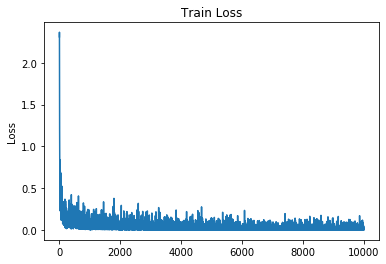

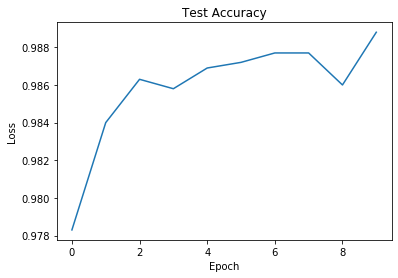

In [1]:
import itertools

import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.125)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 10
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)
    
    train_losses_per_epoch = np.zeros(ITER_PER_EPOCH)
    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(train_losses_per_epoch.mean())
    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        test_accuracies.append(correct / total)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))
        
    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()
plt.plot(train_losses)
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Accuracy')
plt.show()